In [3]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import wandb
import grid2op
from lightsim2grid import LightSimBackend
from gnn.obs_converter import collect_node_and_edge_features_separated
from gnn.torch_geometric_datasets import Grid2opGraphDatasetSoft, Grid2opGraphDatasetProcessed
from gnn.gnn_models import GAT 
from gnn.gnn_prediction import train, train_fast, GnnPrediction 
from torch_geometric.loader import DataLoader
import torch
from pathlib import Path
import os
import pickle
import  matplotlib.pyplot as plt
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool, global_add_pool
#from curriculumagent.teacher.submodule.common import affected_substations
from torch_geometric.data import Data

In [4]:
backend = LightSimBackend()
env_name = "l2rpn_wcci_2022"  # or any other...
env = grid2op.make(env_name, backend=backend)
obs = env.reset()

### Extract Colnames

In [7]:
dataset_colnames= np.load('./data/dataset_colnames.npy')
dataset_colnames = np.append(dataset_colnames, [f"target_{i}" for i in range(2030)])

In [8]:
dataset_colnames


array(['year_0', 'month_0', 'day_0', ..., 'target_2027', 'target_2028',
       'target_2029'], dtype='<U30')

# Extract Dataset

#### Read the data

In [11]:
def read_sample_h5(save_path: Path):
    """Read all states, actions, and max_rhos from the HDF5 file.

    Args:
        save_path: Path to the HDF5 file.

    Returns:
        A list of dictionaries, where each dictionary contains:
        - 'state': The state array.
        - 'action_ids': The list of action IDs.
        - 'max_rhos': The list of max_rhos values.
    """
    results = []
    with h5py.File(save_path, 'r') as f:
        for group_name in f.keys():
            group = f[group_name]
            results.append({
                'state': group['state'][:],
                'action_ids': group['action_ids'][:],
                'max_rhos': group['max_rhos'][:],
            })
    return results

In [13]:
path_to_file = Path("./data/tutor_experience_sample_1000.h5")
data = read_sample_h5(path_to_file)
len(data)

1000

## plot labels with different temprature

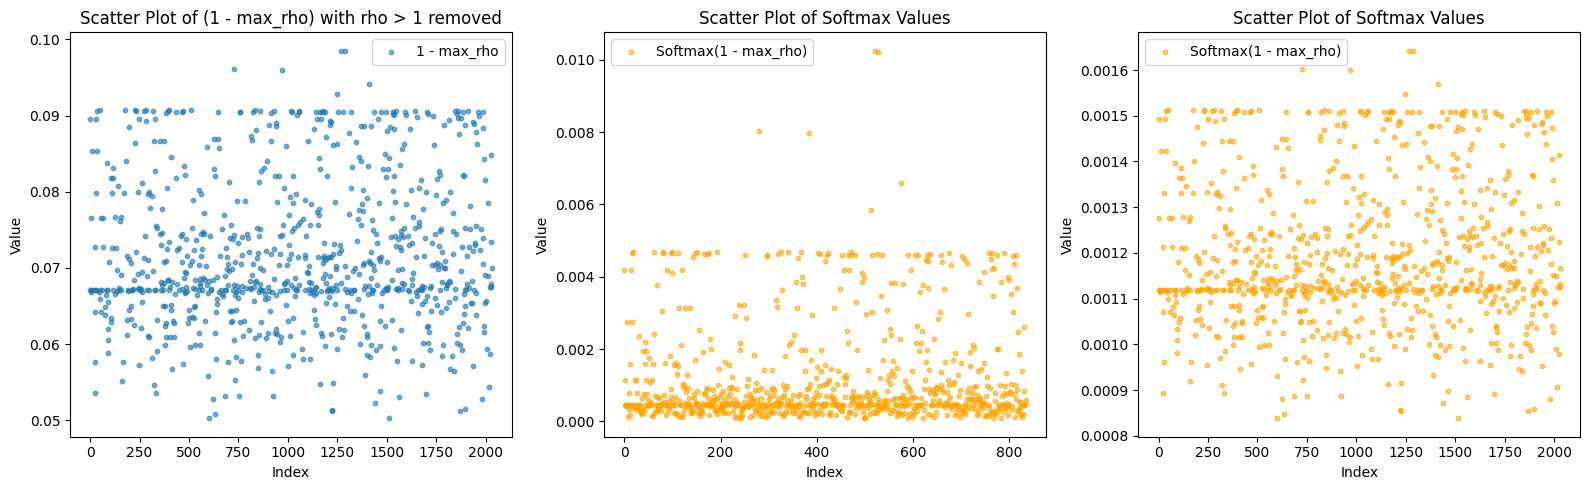

In [22]:
total_ids = 2030
i = np.random.randint(0, 1000) 
# Step 1: Find missing IDs
all_ids = np.arange(total_ids)
action_ids = data[i]["action_ids"]
max_rhos = data[i]["max_rhos"]

missing_ids = np.setdiff1d(all_ids, action_ids)
refilled_ids = np.concatenate([action_ids, missing_ids])
refilled_values = np.concatenate([max_rhos, np.full(len(missing_ids), np.inf)])
refilled_values = refilled_values[np.argsort(refilled_ids)]
refilled_values[refilled_values >= 0.95] = np.inf

#remove index -1 becuase donothing is already present in index 31 (in action space 30)
refilled_values = refilled_values[1:]



# First plot: (1 - refilled_values)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.scatter(x=np.arange(total_ids), y=(1 - refilled_values), s=10, alpha=0.6, label="1 - max_rho")
plt.title("Scatter Plot of (1 - max_rho) with rho > 1 removed")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# Second plot: Softmax distribution with temperature
temperature = 0.01
x = torch.tensor((1 - refilled_values).tolist())  # Convert to PyTorch tensor
softmax_x = F.softmax(x / temperature, dim=0)  # Apply softmax with temperature
softmax_x_np = softmax_x.numpy()

plt.subplot(1, 3, 2)
plt.scatter(
    x=np.arange(softmax_x_np[softmax_x_np > 0].shape[0]),
    y=softmax_x_np[softmax_x_np > 0],
    s=10,
    alpha=0.6,
    color='orange',
    label="Softmax(1 - max_rho)"
)
plt.title("Scatter Plot of Softmax Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()


plt.subplot(1, 3, 3)
plt.scatter(
    x=np.arange(x.shape[0]),
    y=x/torch.sum(x[~torch.isinf(x)]),
    s=10,
    alpha=0.6,
    color='orange',
    label="Softmax(1 - max_rho)"
)
plt.title("Scatter Plot of Softmax Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()


plt.tight_layout()
plt.show()

## Process the data

In [23]:
processed_data = []
temperature = 0.01 

for i in range(len(data)):
    total_ids = 2030
    
    # Find missing IDs
    all_ids = np.arange(total_ids)
    action_ids = data[i]["action_ids"]
    max_rhos = data[i]["max_rhos"]
    missing_ids = np.setdiff1d(all_ids, action_ids)
    refilled_ids = np.concatenate([action_ids, missing_ids])
    refilled_values = np.concatenate([max_rhos, np.full(len(missing_ids), np.inf)])# treat invalid actions as max_rho = +inf
    refilled_values = refilled_values[np.argsort(refilled_ids)]
    refilled_values[refilled_values > 0.95] = np.inf  # treat actions that lead to overloads as max_rho = +inf
    
    #remove index -1 becuase donothing is already present in index 31 (in action space 30)
    refilled_values = refilled_values[1:]

    
    # Softmax distribution with temperature
    x = torch.tensor((1 - refilled_values).tolist())  # Convert to PyTorch tensor
    softmax_x = F.softmax(x / temperature, dim=0)  # Apply softmax with temperature
    softmax_x_np = softmax_x.numpy()

    softmax_x_np = np.nan_to_num(softmax_x_np, nan=0) # replace all nan values with 0
    
    processed_data.append(np.concatenate([data[i]["state"].reshape(-1), softmax_x_np]))


In [24]:
df = pd.DataFrame(processed_data, columns=dataset_colnames)

In [25]:
df.head(10)

year_0  month_0  day_0  hour_of_day_0  minute_of_hour_0  day_of_week_0  \
0  2050.0      3.0   23.0           11.0              50.0            2.0   
1  2050.0      5.0   18.0           10.0              35.0            2.0   
2  2050.0      1.0   11.0           12.0              15.0            1.0   
3  2050.0      3.0   21.0           18.0              40.0            0.0   
4  2050.0      1.0   24.0           14.0              30.0            0.0   
5  2050.0      1.0   24.0            6.0              45.0            0.0   
6  2050.0      2.0    1.0           13.0              35.0            1.0   
7  2050.0      8.0   18.0            9.0               0.0            3.0   
8  2050.0      4.0   20.0           10.0               5.0            2.0   
9  2050.0     12.0   14.0           11.0              15.0            2.0   

      gen_p_0     gen_p_1     gen_p_2     gen_p_3     gen_p_4     gen_p_5  \
0   48.099998   46.200001  360.000000   40.900002   67.900002   69.699997   
1   39.099998   39.200001  191.399994   36.000000  104.500000  107.300003   
2   44.900002   41.900002  359.899994   27.799999   53.000000   51.000000   
3   45.500000   42.799999  360.000000   40.900002    0.000000    0.000000   
4   51.599998   47.400002  360.000000   26.400000   43.900002   44.400002   
5  111.300003  110.000000  360.000000  107.000000    0.000000    0.000000   
6   52.099998   50.599998  360.000000   44.400002   18.100000   19.299999   
7   67.099998   59.799999   53.900002   33.299999   70.599998   68.699997   
8   18.799999   19.799999  359.899994   28.500000   71.900002   69.500000   
9   34.299999   39.500000  241.199997   59.500000   64.300003   66.500000   

   gen_p_6    gen_p_7     gen_p_8    gen_p_9    gen_p_10   gen_p_11  \
0      0.0  64.300003   88.900002  63.799999   58.099998  49.400002   
1      0.0  99.400002    0.000000  95.599998    0.000000  72.800003   
2      0.0  62.799999    0.000000  61.599998    0.000000  49.400002   
3     84.0   0.000000  178.199997   0.000000  178.199997   0.000000   
4      0.0  43.500000   65.199997  44.500000   19.700001  31.600000   
5      0.0   0.000000    0.000000   0.000000    0.000000   0.000000   
6      0.0  15.500000  251.399994  15.400000   79.099998  11.900000   
7      0.0  75.300003    0.000000  76.099998    0.000000  59.700001   
8      0.0  79.599998   15.800000  79.599998    0.000000  59.599998   
9      0.0  61.000000   44.599998  60.799999   36.000000  44.400002   

     gen_p_12    gen_p_13    gen_p_14    gen_p_15   gen_p_16   gen_p_17  \
0   37.900002  360.000000   40.299999   41.000000  37.599998  28.900000   
1   36.799999  192.300003   35.900002   35.000000  63.700001  24.100000   
2   26.600000  359.899994   26.400000   21.799999  55.900002  61.000000   
3   36.299999  360.000000   40.400002   43.099998   0.000000  19.200001   
4   26.900000  360.000000   24.700001   18.600000  40.700001  39.500000   
5  110.199997  356.200012  108.199997  108.000000   0.000000  75.000000   
6   42.000000  360.000000   45.700001   45.400002  29.299999  27.200001   
7   29.299999   55.400002   31.400000   26.400000  62.200001  29.299999   
8   28.400000  359.899994   28.799999   32.799999  59.200001  19.400000   
9   68.900002  241.199997   62.000000   67.000000  50.900002  88.500000   

    gen_p_18    gen_p_19   gen_p_20   gen_p_21   gen_p_22   gen_p_23  \
0  26.900000  175.100006  36.599998  23.600000  46.500000  51.000000   
1  72.699997   54.200001  64.400002  22.200001  82.099998  78.900002   
2  53.000000  162.899994  57.799999  40.400002  76.500000  55.099998   
3   0.000000  178.199997   0.000000  17.100000   0.000000   0.000000   
4  48.299999  206.500000  38.000000  31.900000  47.700001  54.000000   
5   0.000000  163.000000   0.000000  69.800003   0.000000   0.000000   
6  23.100000  251.399994  33.700001  23.799999  48.500000  31.600000   
7  64.199997   13.100000  59.200001  22.600000  75.199997  63.599998   
8  54.099998  122.400002  55.000000  16.500000  69.

In [26]:
df["target_sums"] = df[[f"target_{i}" for i in range(2030)]].sum(axis=1)

In [30]:
df = df[(df["target_sums"] > 0.5)]

In [31]:
df.shape

(874, 6326)

In [33]:
# save as df csv
df.to_csv("./data/unnorm/soft_target_data.csv")

# Read Processed Data and Split 

In [34]:
df = pd.read_csv("./data/unnorm/soft_target_data.csv")

In [35]:
df.drop(columns='Unnamed: 0', inplace=True)

In [36]:
df.drop(columns='target_sums', inplace=True)

In [37]:
pd.options.display.float_format = '{:.4f}'.format

In [38]:
desc = df.describe()

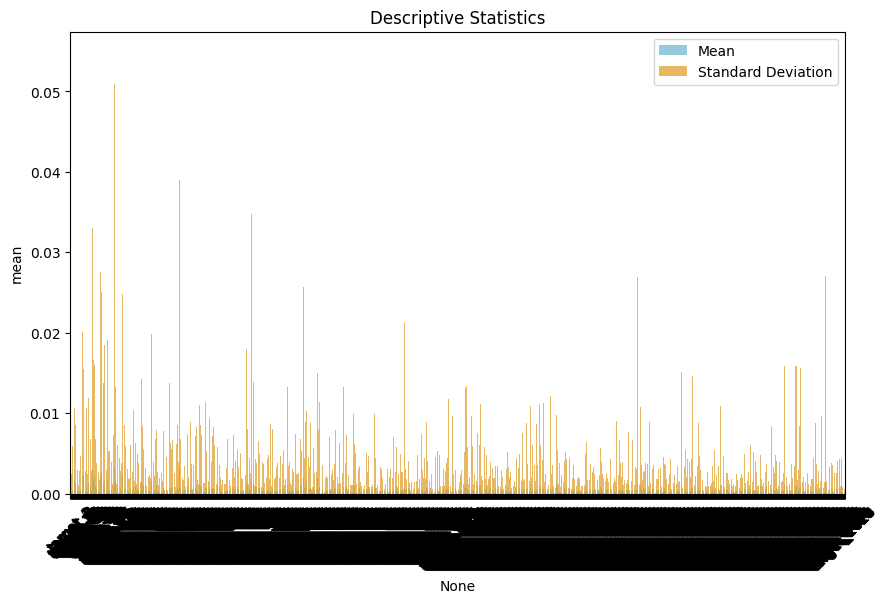

In [39]:
desc_transposed = desc[[f"target_{i}" for i in range(2030)]].T

# Plot using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=desc_transposed.index, y="mean", data=desc_transposed.reset_index(), ax=ax, color="skyblue", label="Mean")
sns.barplot(x=desc_transposed.index, y="std", data=desc_transposed.reset_index(), ax=ax, color="orange", alpha=0.7, label="Standard Deviation")
plt.legend()
plt.xticks(rotation=45)
plt.title("Descriptive Statistics")
plt.show()

## split data

In [40]:
# Split data into train+val and test
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=2323)

# Further split train+val into train and val
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=2323)  # 0.25 x 0.8 = 0.2 of the total

In [41]:
print(train_df.shape, val_df.shape, test_df.shape)

(707, 6325) (79, 6325) (88, 6325)


In [42]:
train_df.to_csv("./data/unnorm/soft_target_data_train.csv")

In [43]:
val_df.to_csv("./data/unnorm/soft_target_data_val.csv")

In [44]:
test_df.to_csv("./data/unnorm/soft_target_data_test.csv")

In [45]:
np.savez('./data/unnorm/soft_target_data.npz', train=train_df.to_numpy(), val=val_df.to_numpy(), test=test_df.to_numpy())

# Create a torch geometric dataset and dataloader

In [46]:
dataset_path = "./data/unnorm/"
dataset_name = "soft_target_data.npz"

In [47]:
d_train = Grid2opGraphDatasetSoft(root=dataset_path, dataset_name=dataset_name, env="l2rpn_wcci_2022", split="train",
                              include_disconnected_lines=True)
d_train.get(0)

0 of 707 rows will be removed due to zero observation
0 of 707 rows will be further be removed due to game over obs


Data(x=[532, 27], edge_index=[2, 3506], y=[2030])

In [48]:
d_val = Grid2opGraphDatasetSoft(root=dataset_path, dataset_name=dataset_name, env="l2rpn_wcci_2022", split="val",
                              include_disconnected_lines=True)
d_val.get(0)

0 of 79 rows will be removed due to zero observation
0 of 79 rows will be further be removed due to game over obs


Data(x=[532, 27], edge_index=[2, 3506], y=[2030])

In [49]:
d_test = Grid2opGraphDatasetSoft(root=dataset_path, dataset_name=dataset_name, env="l2rpn_wcci_2022", split="test",
                              include_disconnected_lines=True)
d_test.get(0)

0 of 88 rows will be removed due to zero observation
0 of 88 rows will be further be removed due to game over obs


Data(x=[532, 27], edge_index=[2, 3506], y=[2030])

In [50]:
backend = LightSimBackend()
env_name = "l2rpn_wcci_2022"  # or any other...
env = grid2op.make(env_name, backend=backend)
obs = env.reset()

## save as processed for faster training

In [51]:
#method to save processed data to disk
def save_processed_data(dl, file_name):
    all_data = []
    
    # Loop through the DataLoader and collect the data
    for batch in dl:
        all_data.extend(batch.to_data_list())
    
    # Save the data using torch or pickle
    torch.save(all_data, file_name)

In [53]:
# create dataloader
batch_size = 1024
num_workers = 1
dl_train = DataLoader(d_train, batch_size=batch_size, num_workers= num_workers, shuffle=False)
dl_val = DataLoader(d_val, batch_size=batch_size, num_workers= num_workers, shuffle=False)
dl_test = DataLoader(d_test, batch_size=batch_size, num_workers= num_workers, shuffle=False)


save_processed_data(dl_train, './data/unnorm/soft_target_data_train_processed.pt')
save_processed_data(dl_val, './data/unnorm/soft_target_data_val_processed.pt')
save_processed_data(dl_test, './data/unnorm/soft_target_data_test_processed.pt')


In [54]:
dataset_path = "./data/unnorm"

dataset_name_train = "soft_target_data_train_processed.pt"
dataset_name_val = "soft_target_data_val_processed.pt"
dataset_name_test = "soft_target_data_test_processed.pt"


In [55]:
d_train_fast = Grid2opGraphDatasetProcessed(root=dataset_path, dataset_name=dataset_name_train, env="l2rpn_wcci_2022", split="train",
                              include_disconnected_lines=True)
d_val_fast = Grid2opGraphDatasetProcessed(root=dataset_path, dataset_name=dataset_name_val, env="l2rpn_wcci_2022", split="val",
                              include_disconnected_lines=True)
d_test_fast = Grid2opGraphDatasetProcessed(root=dataset_path, dataset_name=dataset_name_test, env="l2rpn_wcci_2022", split="test",
                              include_disconnected_lines=True)

In [56]:
dl_trainfast = DataLoader(d_train_fast, batch_size=64, num_workers= 1, shuffle=False)


## create a scaler from training data

In [57]:
data = torch.load('./data/unnorm/soft_target_data_train_processed.pt')


In [58]:
data[0]

Data(x=[532, 27], edge_index=[2, 3506], y=[2030])

In [59]:
scaler = StandardScaler()
# Fit the scaler on all features
for d in data:
    scaler.partial_fit(d.x)
print(scaler.mean_)


[ 1.08197031e+00  1.71539173e-02  6.06339505e+00  4.24436223e+00
  2.39752664e+01  6.28034831e+00  2.87791187e+00  1.86135714e+01
  2.71869118e+00  0.00000000e+00  5.50434331e+00  2.23577049e-01
  5.67798680e+01  6.05307497e+01 -5.28739004e+00 -1.59002741e+00
  5.24773153e+01  6.96325886e+01  2.76504557e-04  6.98025119e-01
  2.69989797e-01  3.10332763e+00  5.26459359e-01  2.56192107e-02
  2.48120301e-01  0.00000000e+00  0.00000000e+00]


In [61]:
# save scaler 
with open('./data/scaler_all.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## normalize data and resave

In [62]:
#method to save processed data to disk
def normalize_processed_data(data_path, scaler_path, save_name):
    data = torch.load(data_path)
    if isinstance(scaler_path, (str, Path)):
        try:
            with open(scaler_path, "rb") as fp:  # Pickling
                scaler = pickle.load(fp)
        except Exception as e:
            print(f"The scaler provided was either a path or a string. However, loading "
                         f"the scaler cause the following exception:{e}"
                         f"It will be set to None")
    for d in data:
        d.x = torch.tensor(scaler.transform(d.x.numpy()), dtype=torch.float)
    # Save the data using torch or pickle
    torch.save(data, save_name)

In [63]:
normalize_processed_data(data_path= "./data/unnorm/soft_target_data_train_processed.pt", scaler_path = "./data/scaler_all.pkl", save_name = "./data/norm/soft_target_data_train_processed_norm.pt")

In [64]:
normalize_processed_data(data_path= "./data/unnorm/soft_target_data_val_processed.pt", scaler_path = "./data/scaler_all.pkl", save_name = "./data/norm/soft_target_data_val_processed_norm.pt")

In [65]:
normalize_processed_data(data_path= "./data/unnorm/soft_target_data_test_processed.pt", scaler_path = "./data/scaler_all.pkl", save_name = "./data/norm/soft_target_data_test_processed_norm.pt")